In [42]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy as hc
from sklearn import metrics as m

import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

sns.set()


In [3]:
df = pd.read_csv(join("cluster_preprocessed.csv"))

In [5]:
df.head(1)

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,x_EducDeg_Basic,x_EducDeg_High_School,x_EducDeg_PhD,x_Children_True,PC0,PC1,PC2
0,-0.282263,-1.353182,0.10282,-0.120022,-0.796412,-0.214005,0.0,1.0,0.0,1.0,-0.179018,-0.747969,-1.333249


In [6]:
df.columns

Index(['MonthSal', 'GeoLivArea', 'CustMonVal', 'ClaimsRate', 'Age',
       'Total_Prem', 'x_EducDeg_Basic', 'x_EducDeg_High_School',
       'x_EducDeg_PhD', 'x_Children_True', 'PC0', 'PC1', 'PC2'],
      dtype='object')

In [7]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

# Hierarchical Clustering

In [8]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df[metric_features])
hc_labels

array([2, 2, 1, ..., 0, 2, 2])

In [9]:
# Characterizing the clusters
df_concat = pd.concat((df, pd.Series(hc_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,x_EducDeg_Basic,x_EducDeg_High_School,x_EducDeg_PhD,x_Children_True,PC0,PC1,PC2
labels,,,,,,,,,,,,,
0,0.561696,-1.135202,-0.017682,0.008652,0.685261,-0.108981,0.081580,0.331043,0.074710,0.598111,0.029659,0.860289,-1.009979
1,0.533080,0.775598,0.019327,-0.024459,0.648171,-0.079647,0.078649,0.342043,0.073370,0.599367,-0.002769,0.856224,0.691657
2,-0.861332,-0.076952,0.013323,-0.003598,-1.048689,0.114999,0.196063,0.351463,0.055944,0.874644,-0.045177,-1.352922,-0.083596
3,-1.219346,1.015440,-83.952310,86.263843,-1.197937,-0.248429,0.000000,0.000000,0.000000,1.000000,120.229079,-4.838591,1.578856
4,-0.603929,0.620670,0.233323,0.077526,-0.853773,55.918688,0.000000,1.000000,0.000000,1.000000,-2.194050,-9.688323,26.369840


## Linkage method to choose:

In [10]:
# Computing SST
X = df[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True])

In [11]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

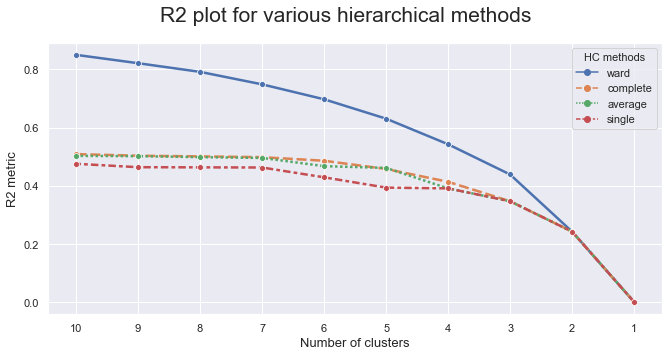

In [12]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

## Defining the number of clusters:

In [13]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[metric_features])

array([5639, 8424, 6239, ...,    3,    1,    0])

In [16]:
hc_model = hc.linkage(df[metric_features], 'ward')

[]

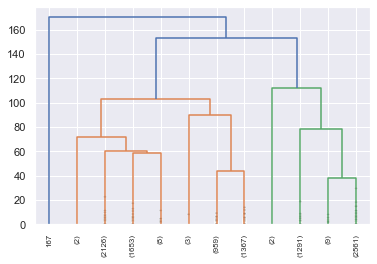

In [18]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation = 90,
   leaf_font_size=8,
    show_contracted=True
)

plt.plot()

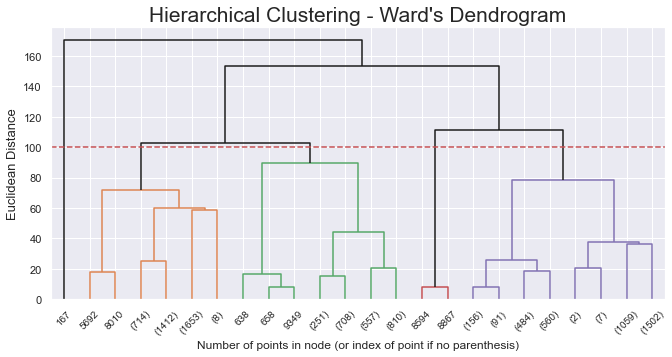

In [19]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [20]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df[metric_features])

In [21]:
# Characterizing the 4 clusters
df_concat = pd.concat((df, pd.Series(hc4_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,x_EducDeg_Basic,x_EducDeg_High_School,x_EducDeg_PhD,x_Children_True,PC0,PC1,PC2
labels,,,,,,,,,,,,,
0,0.543974,0.048195,0.005238,-0.011854,0.662291,-0.090814,0.079765,0.337856,0.073880,0.598889,0.009576,0.857771,0.043878
1,-0.603929,0.620670,0.233323,0.077526,-0.853773,55.918688,0.000000,1.000000,0.000000,1.000000,-2.194050,-9.688323,26.369840
2,-0.861332,-0.076952,0.013323,-0.003598,-1.048689,0.114999,0.196063,0.351463,0.055944,0.874644,-0.045177,-1.352922,-0.083596
3,-1.219346,1.015440,-83.952310,86.263843,-1.197937,-0.248429,0.000000,0.000000,0.000000,1.000000,120.229079,-4.838591,1.578856


In [22]:
# 3 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc5lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc5_labels = hc5lust.fit_predict(df[metric_features])

In [23]:
# Characterizing the 3 clusters
df_concat = pd.concat((df, pd.Series(hc5_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,x_EducDeg_Basic,x_EducDeg_High_School,x_EducDeg_PhD,x_Children_True,PC0,PC1,PC2
labels,,,,,,,,,,,,,
0,-0.861199,-0.076591,0.013437,-0.003556,-1.048588,0.143890,0.195962,0.351799,0.055915,0.874709,-0.046289,-1.357237,-0.069900
1,-1.219346,1.015440,-83.952310,86.263843,-1.197937,-0.248429,0.000000,0.000000,0.000000,1.000000,120.229079,-4.838591,1.578856
2,0.543974,0.048195,0.005238,-0.011854,0.662291,-0.090814,0.079765,0.337856,0.073880,0.598889,0.009576,0.857771,0.043878


# K-Means

In [25]:
kmclust = KMeans(n_clusters=8, init='random', n_init=10, random_state=1)
# the fit method
kmclust.fit(df[metric_features])

KMeans(init='random', random_state=1)

In [26]:
# the predict method
kmclust.predict(df[metric_features])

array([6, 4, 7, ..., 6, 6, 6], dtype=int32)

In [27]:
# the transform method
pd.DataFrame(kmclust.transform(df[metric_features]))

,0,1,2,3,4,5,6,7
0,32.585061,0.905915,3.116747,2.286523,2.291505,57.642191,0.826695,2.240349
1,32.122119,2.310208,3.694220,4.252314,0.778982,57.332310,3.107849,2.207169
2,32.358045,1.942693,1.775030,2.157719,1.466629,57.684375,1.425002,0.593696
3,32.711547,2.306703,2.878357,3.572751,0.797957,57.367686,2.577999,1.382530
4,32.615937,2.431117,2.147635,3.018683,1.118378,57.385590,2.277823,0.694522
...,...,...,...,...,...,...,...,...
9977,32.591626,2.853464,1.399697,0.725351,3.099849,57.340098,1.439448,1.866231
9978,30.905958,3.006262,1.950821,2.293300,2.717108,58.092548,2.417409,2.042672
9979,32.501566,1.569823,2.714905,1.704283,2.630303,57.724586,0.648803,2.186765
9980,32.319590,1.045259,2.529050,2.212580,1.576376,57.517140,0.898890,1.458526


## Improve the initialization step

In [28]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[metric_features])

KMeans(n_init=15, random_state=1)

In [29]:
kmclust.predict(df[metric_features])

array([7, 0, 0, ..., 7, 7, 7], dtype=int32)

## Defining the number of clusters:

In [30]:
range_clusters = range(1, 11)

In [31]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_) 

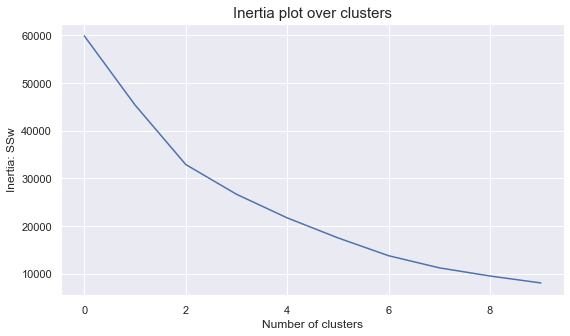

In [35]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.9807940297904045
For n_clusters = 3, the average silhouette_score is : 0.35989051852141285
For n_clusters = 4, the average silhouette_score is : 0.3613251640204967
For n_clusters = 5, the average silhouette_score is : 0.3703841092309622
For n_clusters = 6, the average silhouette_score is : 0.37038556921546434
For n_clusters = 7, the average silhouette_score is : 0.40117659420210994
For n_clusters = 8, the average silhouette_score is : 0.4010681253970973
For n_clusters = 9, the average silhouette_score is : 0.4037442942406288
For n_clusters = 10, the average silhouette_score is : 0.3688611515451256


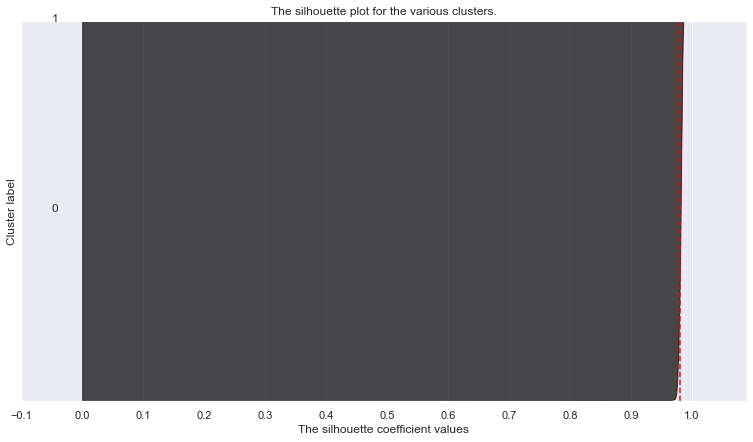

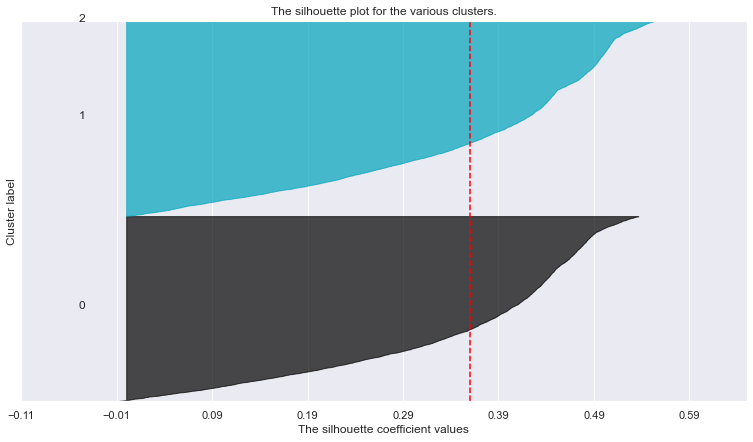

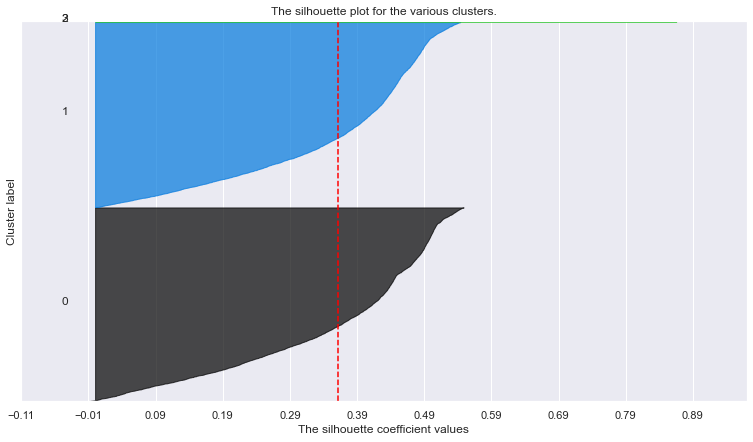

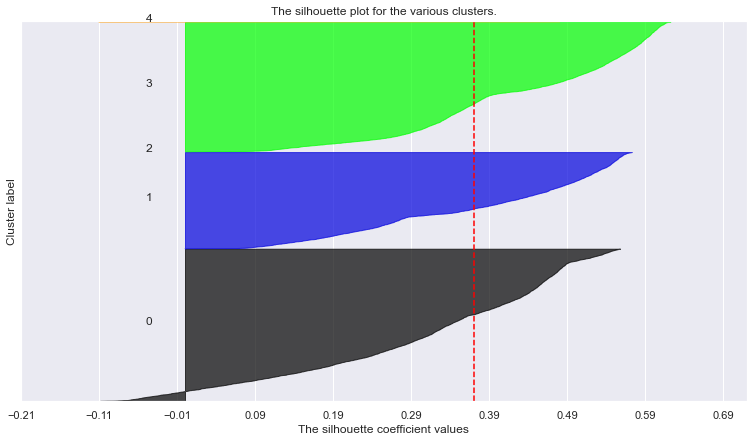

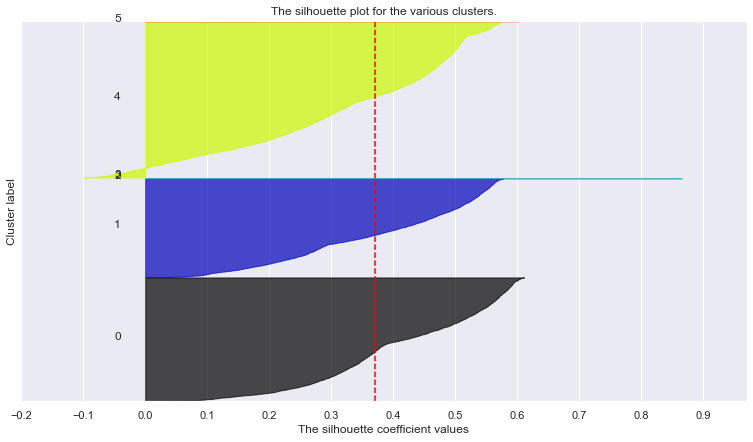

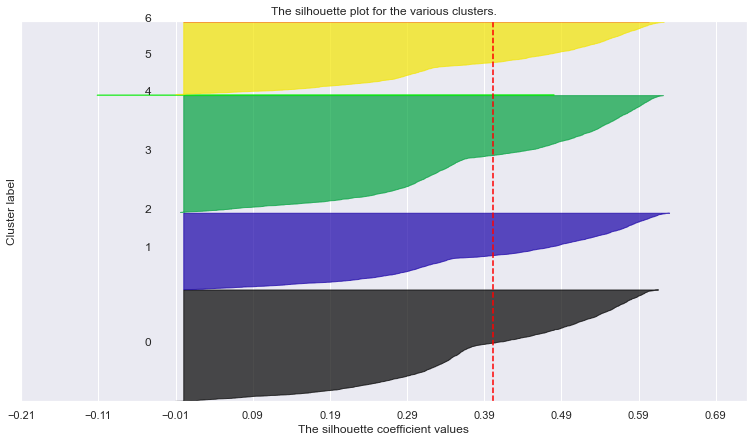

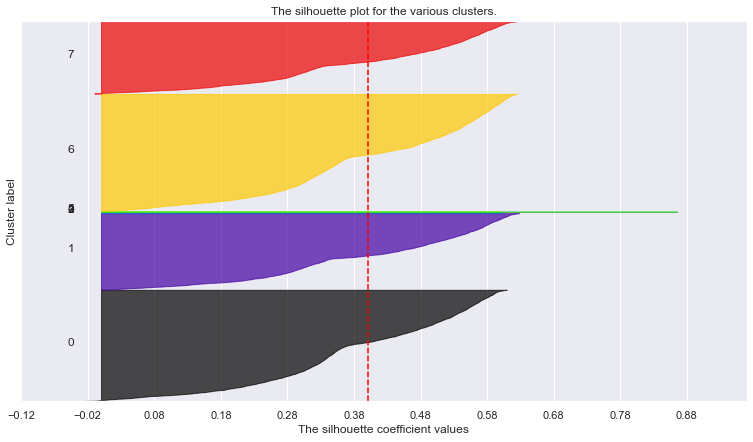

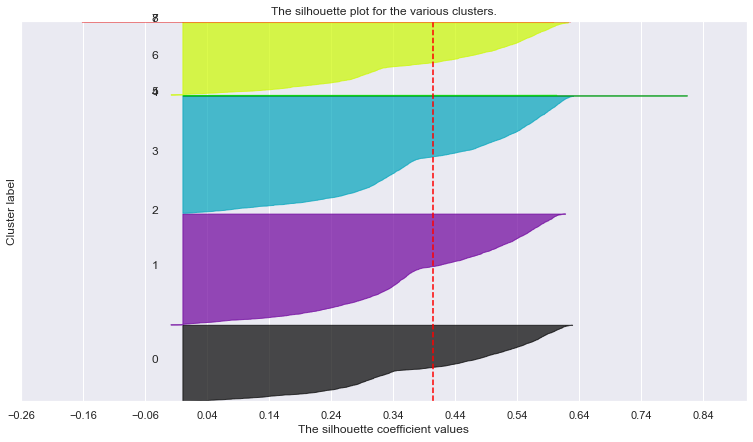

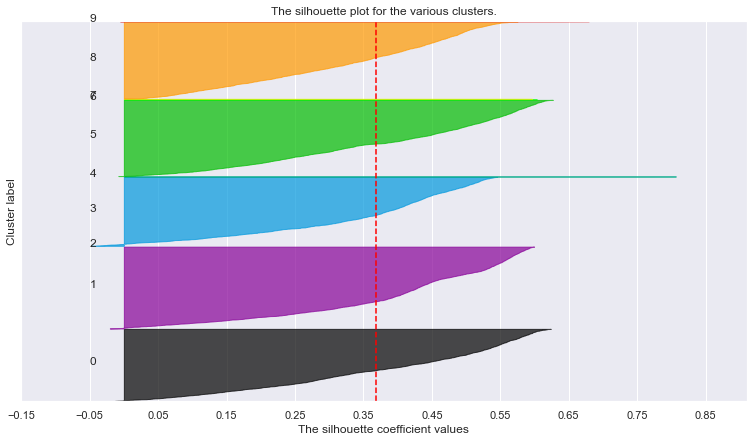

In [33]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

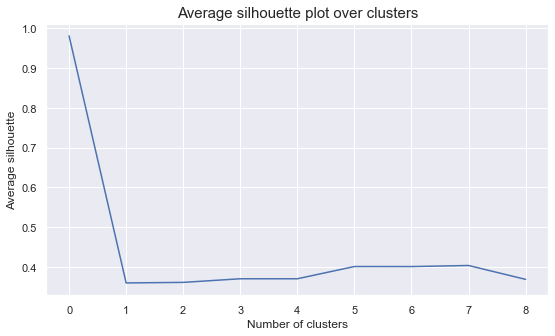

In [34]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final KMeans 

In [36]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df[metric_features])
km_labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [37]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,MonthSal,GeoLivArea,CustMonVal,ClaimsRate,Age,Total_Prem,x_EducDeg_Basic,x_EducDeg_High_School,x_EducDeg_PhD,x_Children_True,PC0,PC1,PC2
labels,,,,,,,,,,,,,
0,0.697793,0.016366,-0.002975,-0.003407,0.838985,-0.074185,0.080557,0.341435,0.074677,0.533516,0.025289,1.084866,0.035460
1,-0.729488,-0.017584,0.020230,-0.014155,-0.877096,0.054727,0.171007,0.344884,0.058848,0.885585,-0.050208,-1.129951,-0.048233
2,-0.603929,0.620670,0.233323,0.077526,-0.853773,55.918688,0.000000,1.000000,0.000000,1.000000,-2.194050,-9.688323,26.369840
3,-1.219346,1.015440,-83.952310,86.263843,-1.197937,-0.248429,0.000000,0.000000,0.000000,1.000000,120.229079,-4.838591,1.578856
